<a href="https://colab.research.google.com/github/kodikarthik21/CS6910---Fundamentals-of-Deep-Learning/blob/main/Assignment02/Assignment2_PartA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install wandb

ERROR: Operation cancelled by user


In [11]:
import wandb
wandb.login()

wandb: Currently logged in as: kodikarthik21 (use `wandb login --relogin` to force relogin)


True

In [12]:
#--------------STORE nature_12K.zip in My Drive and run the following code------
!unzip '/content/drive/MyDrive/nature_12K'

Archive:  /content/drive/MyDrive/nature_12K.zip
replace inaturalist_12K/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [39]:
import numpy as np
import tensorflow as tf 
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras import backend as K
from PIL import Image
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from numpy.random import seed
from numpy.random import randint
import pandas as pd
tf.test.gpu_device_name()

'/device:GPU:0'

#Part A: Training from scratch
##Question 1 (5 Marks)



Build a small CNN model consisting of  5 convolution layers. Each convolution layer would be followed by a ReLU activation and a max pooling layer. Here is sample code for building one such conv-relu-maxpool block in keras. 

After 5 such conv-relu-maxpool blocks of  layers you should have one dense layer followed by the output layer containing 10 neurons (1 for each of the 10 classes). The input layer should be compatible with the images in the iNaturalist dataset.






In [6]:
def model_framework(): 
#---------DEFAULT HYPERPARAMETERS-----------------------------------------------
  hyperparameter_defaults = dict(
        max_epoch = 10,
        num_filters = 128,
        filter_org = 'double',
        data_augmentation = 'N',
        dropout = 0.4,
        batch_normalization = 'Y',
        optimizer = 'nag'
      )
  
#----------------SETTING UP WANDB-----------------------------------------------
  wandb.init(project="Assignment 2", config=hyperparameter_defaults)
  config = wandb.config
  wandb.run.name = "{}_epoch_{}_filt_{}_FiltOrg_{}_DataAug_{}_dropout_{}_bn_{}_opt".format(config.max_epoch, config.num_filters,config.filter_org, config.data_augmentation, config.dropout, config.batch_normalization, config.optimizer)

#-------------------OPTIMIZERS--------------------------------------------------
  learning_rate = 1e-3
  decay_rate = learning_rate / config.max_epoch
  momentum = 0.8
  if config.optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate, decay=decay_rate)
  elif config.optimizer == 'nadam':
    optimizer = tf.keras.optimizers.Nadam(lr=learning_rate, decay=decay_rate)
  elif config.optimizer == 'rmsprop':
    optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate, decay=decay_rate)
  elif config.optimizer == 'nag':
    optimizer = tf.keras.optimizers.SGD(lr=learning_rate, decay=decay_rate, nesterov=True)

#-------------------DATA AUGMENTATION-------------------------------------------
  IMG_SIZE = 256

  data_aug = tf.keras.Sequential([preprocessing.RandomFlip(),
                                  preprocessing.RandomCrop(IMG_SIZE, IMG_SIZE),
                                  preprocessing.RandomRotation(factor = (-0.2, 0.2)),
                                  preprocessing.RandomTranslation(height_factor=(-0.2, 0.2), 
                                                                  width_factor=(-0.2,0.2)),
                                ])

#-------------------MODEL FRAMEWORK---------------------------------------------
  nf = config.num_filters

  if config.data_augmentation == "Y":
    model = Sequential([data_aug])
  elif config.data_augmentation == "N":
    model = Sequential()

  model.add(Conv2D(nf, (3, 3), input_shape=(256, 256, 3),name = 'conv1'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2),strides = 1))

  for i in range(1,5):
    if config.filter_org == 'double':
      nf = nf*2
    elif config.filter_org == 'half':
      nf = nf/2
    model.add(Conv2D(nf, (3, 3),name = 'conv{}'.format(i+1)))
    model.add(Activation('relu'))
    if config.batch_normalization == 'Y':
      model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(64))
  model.add(Dropout(config.dropout))
  model.add(Activation('relu'))
  model.add(Dense(10))
  model.add(Activation('softmax'))
 
 #------------MODEL COMPILATION--------------------------------------
  model.compile(optimizer=optimizer,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

  return model,config 

def train(model,config):
#------------MODEL TRAINING--------------------------------------

  model.fit(train_dataset, validation_data = validation_dataset, batch_size = 32, epochs = config.max_epoch, callbacks=[WandbCallback()] )
  
  model.summary()   

  return model

def test(model):
#-----------MODEL EVALUATION WITH TEST DATA-------------------------------------
  wandb.init(project="Assignment 2")
  wandb.run.name = "Test_run_for_best_model"
  results = model.evaluate(test_dataset, batch_size=128,callbacks=[WandbCallback()])
  wandb.log({'test_loss': results[0], 'test_accuracy': results[1]})

#Question 2 (10 Marks)



You will now train your model using the iNaturalist dataset. The zip file contains a train and a test folder. Set aside 10% of the training data for hyperparameter tuning. Make sure each class is equally represented in the validation data. Do not use the test data for hyperparameter tuning. Using the sweep feature in wandb find the best hyperparameter configuration. 





In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/inaturalist_12K/train',labels = 'inferred', 
                                                                    validation_split=0.1, seed = 123, subset = "training")

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/inaturalist_12K/train', labels = 'inferred',
                                                                    validation_split=0.1, seed = 123, subset = "validation")

test_dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/inaturalist_12K/val', labels = 'inferred',seed = 123)


Found 9999 files belonging to 10 classes.
Using 9000 files for training.
Found 9999 files belonging to 10 classes.
Using 999 files for validation.
Found 2000 files belonging to 10 classes.


In [ ]:
#--------------------------SWEEP HYPERPARAMETERS--------------------------------
sweep_config = {
  "name": "My Sweep",
  "method": "random",
  "project": "Assignment02",
  "metric":{
      "name":"val_accuracy",
      "goal":"maximize"
  },
  "parameters": {
        "max_epoch": {
            "values": [10,20]
        },
        "num_filters": {
            "values":[16,32,64]
        }, 
        "filter_org": {
            "values":['same','double','half']
        },
        "data_augmentation":{
            "values":['Y',"N"]
        },
        "dropout":{
            "values":[0, 0.2,0.3,0.4]
        },
        "batch_normalization": {
            "values":['Y',"N"]
        },  
        "optimizer": {
            "values":['adam', 'nadam','rmsprop','nag']
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

In [ ]:
#-------------------------CODE FOR ACTUAL SWEEP---------------------------------
model,config = model_framework()
# model = train(model,config)     FOR ONE RUN
# wandb.agent(sweep_id, function=train(model,config))  FOR SWEEP


#Question 4 (5 Marks)



You will now apply your best model on the test data (You shouldn't have used test data so far. All the above experiments should have been done using train and val data only). 



(a) Use the best model from your sweep and report the accuracy on the test set. 





In [16]:
#-----------------LOADING THE BEST MODEL FROM THE SWEEP-------------------------
model = tf.keras.models.load_model(wandb.restore('model-best.h5', run_path="kodikarthik21/Assignment 2/m5pfdn04").name)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 128)     3584      
_________________________________________________________________
activation (Activation)      (None, 254, 254, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 256)     295168    
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 256)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 512)      

In [ ]:
#-------------FINDING TEST LOSS AND ACCURACY FOR THE BEST MODEL-----------------
test(model)
wandb.run.finish()

(b) Provide a 10 x 3 grid containing sample images from the test data and predictions made by your best model (more marks for presenting this grid creatively).

In [ ]:
#-----------COMPARING PREDICTED AND ACTUAL OUTPUTS FROM TEST DATASET------------

class_names = test_dataset.class_names
#model = tf.keras.models.load_model(wandb.restore('model-best.h5', run_path="kodikarthik21/Assignment 2/m5pfdn04").name)
ds = test_dataset.take(1)
y_prob = model.predict(ds) 
y_classes = y_prob.argmax(axis=-1)
plt.figure(figsize=(10, 10))
for images,labels in ds:
  for i in range(30):
    wandb.init(project="Assignment 2")
    wandb.run.name = "Actual: {}".format(class_names[labels[i]])  
    #ax = plt.subplot(4,3,(j+1,i+1))
    #plt.imshow(images[i].numpy().astype("uint8"))
    if labels[i] == y_classes[i]:
       wandb.log({"Test": [wandb.Image(images[i].numpy().astype("uint8"), caption="PREDICTED SAME AS ACTUAL")]})
    else:
      wandb.log({"Test": [wandb.Image(images[i].numpy().astype("uint8"), caption="Predicted: {}".format(class_names[y_classes[i]]))]})
    #plt.title([class_names[labels[k]],class_names[y_classes[i]]])
    #plt.axis("off")
    wandb.run.finish()
  break;

(c) Visualise all the filters in the first layer of your best model for a random image from the test set. If there are 64 filters in the first layer plot them in an 8 x 8 grid. 

In [ ]:
#---------------VISUALIZING FILTERS IN THE 1ST CONV LAYER-----------------------

# model = tf.keras.models.load_model(wandb.restore('model-best.h5', run_path="kodikarthik21/Assignment 2/m5pfdn04").name)
model = Model(inputs=model.inputs, outputs=model.layers[0].output)

img = load_img("inaturalist_12K/val/Mammalia/9e014930ee1bd2f4079320ec01ce8858.jpg")
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = load_image("inaturalist_12K/val/Mammalia/9e014930ee1bd2f4079320ec01ce8858.jpg")
feature_maps = model.predict(img)
for i in range(128):
  wandb.init(project="Assignment 2")
  wandb.run.name = "Filter_viz {}".format(i+1)  
  wandb.log({"Filter": [wandb.Image(feature_maps[0, :, :, i], caption=i+1)]})
  wandb.run.finish()

#Question 5 (10 Marks)



Apply guided back propagation on any 10 neurons in the CONV5 layer and plot the images which excite this neuron. The idea again is to discover interesting patterns which excite some neurons. You will draw a 10 x 1 grid below with one image for each of the 10 neurons.





In [42]:
#---------Deprocessing image for Guided Backpropagation---------
def deprocess_image(x):
    #-------Normalizing the images--------
    x = x.copy()
    x -= x.mean()
    x /= (x.std() + K.epsilon())

    #------Make output between 0 and 1----
    x = np.clip(x, 0, 1)

    #------Coloring-------
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

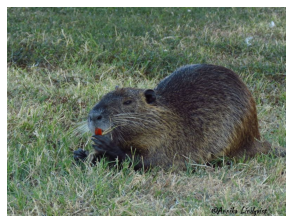

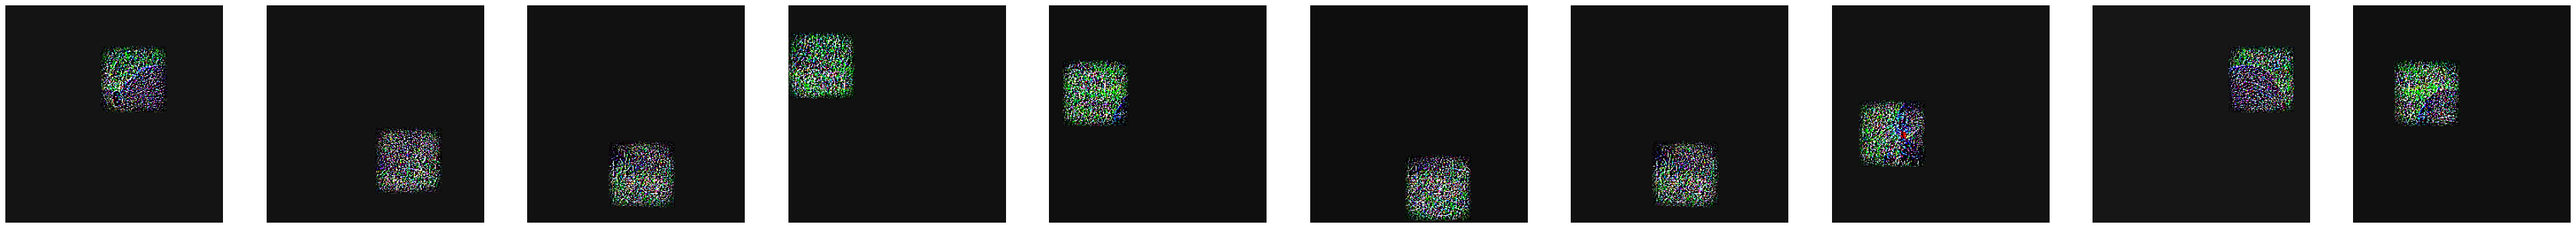

In [43]:
#------------GUIDED BACKPROPAGATION---------------------------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 12))

#wandb.init(project="Assignment 2")
#wandb.run.name = "Guided BackPropagation"

#-----------Load an image-------------
plt.imshow(Image.open("inaturalist_12K/val/Mammalia/9e014930ee1bd2f4079320ec01ce8858.jpg"))
plt.axis("off");
plt.figure(figsize=(60, 60))
#wandb.log({"Guided_BackProp": [wandb.Image(Image.open("inaturalist_12K/val/Mammalia/9e014930ee1bd2f4079320ec01ce8858.jpg"), caption='Original')]})
plt.axis("off");

#-----------Guided Relu to remove negative gradients-------------
@tf.custom_gradient
def guidedRelu(x):
  def grad(dy):
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  return tf.nn.relu(x), grad


for i in range(10):
  
  #wandb.init(project="Assignment 2")
  #wandb.run.name = "Guided BackPropagation {}".format(i+1)  

  # model = tf.keras.models.load_model(wandb.restore('model-best.h5', run_path="kodikarthik21/uncategorized/m5pfdn04").name) 
  # model.summary()

  #-----------Get outputs from CONV5 layer------------
  gb_model = Model(
      inputs = [model.inputs],
      outputs = [model.get_layer('conv2d_4').output]  # Numbering starts from 0. Therefore 5th conv layer is conv2d_4
  )

  outputs = model.get_layer('conv2d_4').output
  #-----------Selecting neurons at random from CONV5 Layer and doing Guided Backprop
  rand2 = randint(outputs.shape[1])
  rand3 = randint(outputs.shape[2])
  rand4 = randint(outputs.shape[3])

  #-----------Creating a dummy array------------
  modif = np.zeros((outputs.shape[1],outputs.shape[2],outputs.shape[3]))
  modif[rand2][rand3][rand4] = 1; # Array to be multiplied with output for guided backprop

  #-----------Changing activation to Guided Relu to make negative gradients to ZERO-----------
  layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
  for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
      layer.activation = guidedRelu

  #-----------Making all the other inputs ZERO------------
  with tf.GradientTape() as tape:
    inputs = tf.cast(preprocessed_input, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)*modif # To assign all outputs to zero and only this to one

  #-----------Calculate gradients with the updated outputs and remove negative gradients------------
  grads = tape.gradient(outputs,inputs)[0]
  plt.subplot(1,10,i+1)
  plt.imshow(np.flip(deprocess_image(np.array(grads)),-1))
  #wandb.log({"Guided_BackProp": [wandb.Image(np.flip(deprocess_image(np.array(grads)),-1), caption=i+1)]})
  plt.axis("off");